In [461]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [462]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']
columns =  eye_data_names + channels

data, header = pyxdf.load_xdf('data/LSLDataV2/LSLDataLeftFourTimes2/eeg-and-eyetracking.xdf')


In [463]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [464]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [465]:

def init_data(data):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        return stream, df_stream, df_stream_ts

stream, df_stream, df_stream_ts = init_data(data)
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [466]:
avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

In [467]:
start, end = get_time_stamps(left_blinks)
flip = False
chosen_channel = 'AUX_1'
print(start)
print(end)


[1201, 1510, 1858]
[1278, 1576, 1917]


In [468]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 0.75
highcut = 100


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_eeg_blink_single_norm_butter(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = butter_bandpass_filter((df_norm + plus) *(-1 if flip else 1) *scale, lowcut, highcut, fs, order=order)
    peaks, _ = signal.find_peaks(y, height=0.5)

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

def get_peaks(df, start, end, column, rang=50, scale=1, order=5, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = butter_bandpass_filter((df_norm + plus) *(-1 if flip else 1) *scale, lowcut, highcut, fs, order=order)
    peaks, _ = signal.find_peaks(y, height=0)
    return peaks[np.argmax([y[i] for i in peaks])]+ start - rang ## Get only highest blink onset



In [469]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

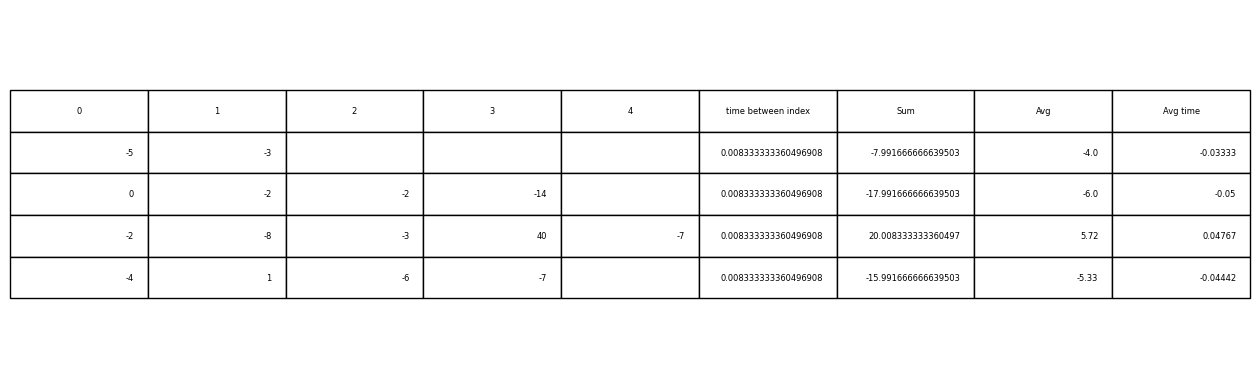

In [470]:
paths = ['LSLData4BothBlink', 'LSLDataBothFiveTimesFIR', 'LSLDataBothSlow4Times2', 'LSLDataBothSlow4TimesFIR']
flip_paths = [False,True, True, True]
def run_files(paths, flip_paths, path='data/LSLDataV2/', both = True):
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):
        data, header = pyxdf.load_xdf(path+str(y)+'/eeg-and-eyetracking.xdf')
        stream, df_stream, df_stream_ts = init_data(data)
        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(both_blink if both else left_blinks)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())
        peaks = []
        for i in range(len(start)):
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=50, scale=5, flip=flip_paths[index], order=5))

        shift = find_shift(start, peaks)
        peak_info.append(shift)

    n = len(max(peak_info, key=len))
    t = [x + [None]*(n-len(x)) for x in peak_info]
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    df_peak['time between index'] = [i[0] for i in avg_time]
    df_peak['Sum'] = df_peak.sum(axis=1)
    df_peak['Avg'] = round(df_peak.mean(axis=1),2)
    df_peak['Avg time'] = round(df_peak['Avg']*df_peak['time between index'],5)
    plot_table(df_peak)

run_files(paths, flip_paths)



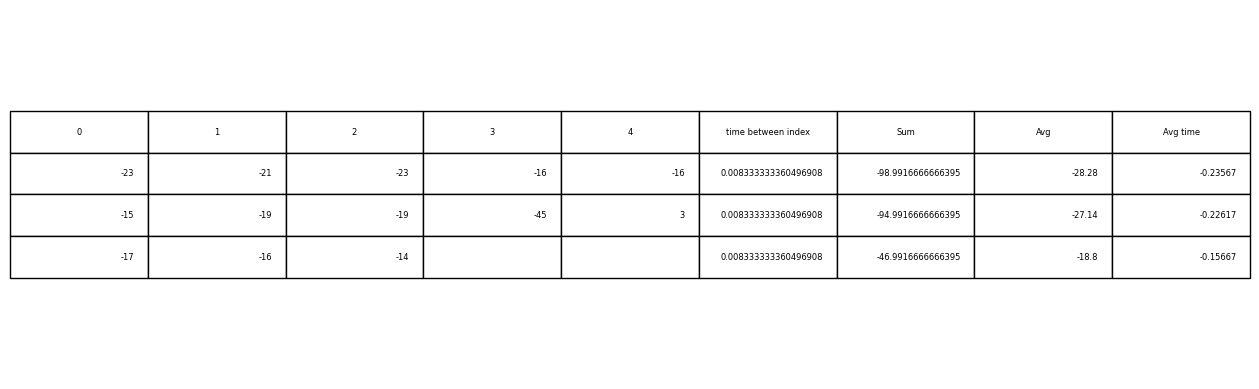

In [471]:
paths = ['LSLDataLeft5times2FIR', 'LSLDataLeft5TimesFIR', 'LSLDataLeftFourTimes2']
flip_paths = [False, False, False]
run_files(paths, flip_paths, both=False)